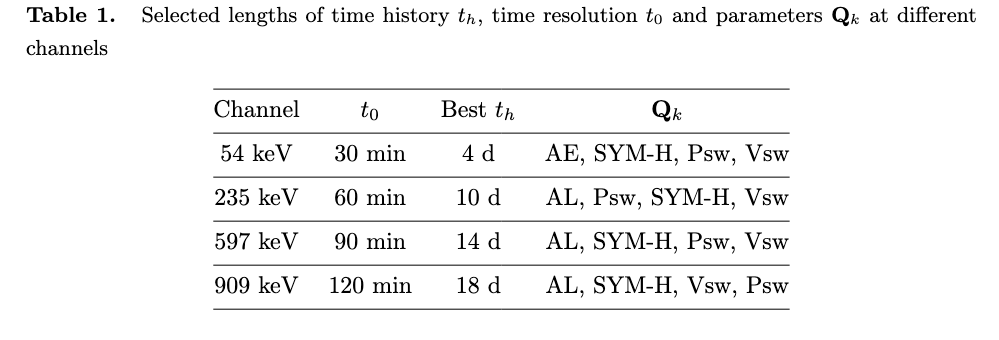

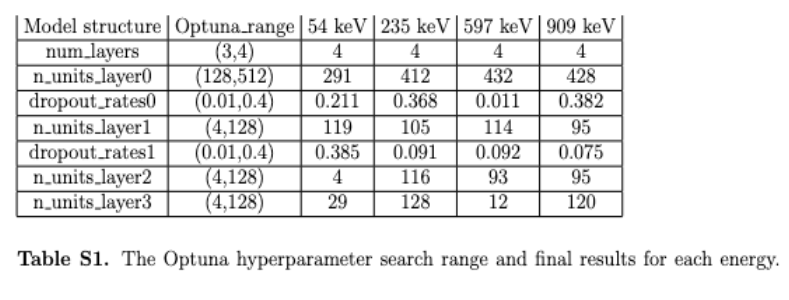

In [2]:
import pickle
import zipfile
import os
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
zip_file_path = '/content/drive/MyDrive/Radiation_Belt_Project/ch3_processed.zip'
extract_dir = '/content/data/'

In [6]:
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}:")

Files extracted to /content/data/:


Data Loading

In [7]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [8]:
X_train = load_pickle(os.path.join(extract_dir, 'X_train_norm.pkl'))
y_train = load_pickle(os.path.join(extract_dir, 'y_train.pkl'))

X_val = load_pickle(os.path.join(extract_dir, 'X_val_norm.pkl'))
y_val = load_pickle(os.path.join(extract_dir, 'y_val.pkl'))


In [9]:
#Out of sample storm data
X_test_storm = load_pickle(os.path.join(extract_dir, 'X_test_storm_norm.pkl'))
y_test_storm = load_pickle(os.path.join(extract_dir, 'y_test_storm.pkl'))

In [10]:
input_dim = X_train.shape[1]
print(input_dim)

1156


According to Table 1 in the paper, for the 54 keV channel, the authors found the optimal parameters to be:

History Length (t
h
​
 ): 4 days

Time Resolution (t
0
​
 ): 30 minutes
This means the required number of features per parameter is:

(4 days * 24 hours/day * 60 minutes/hour) / 30 minutes/step = 192 time steps.

Our feature list shows columns going up to _t_287, which is 288 steps.

 This confirms our initial preprocessing was done with a longer time history than required for this specific channel. Therefore, we must now select only the first 192 time steps (from _t_0 to _t_191) for each of the selected input parameters to precisely match the paper's methodology for the 54 keV model.

In [11]:
positional_features = ["ED_R_OP77Q_intxt","ED_MLAT_OP77Q_intxt","ED_MLT_OP77Q_intxt_sin","ED_MLT_OP77Q_intxt_cos"]

selected_time_series_prefixes = ["AE_INDEX","flow_speed","SYM_H","Pressure"]

num_time_steps = 192

columns_to_keep = []

columns_to_keep.extend(positional_features)

for prefix in selected_time_series_prefixes:
    for i in range(num_time_steps):
        columns_to_keep.append(f"{prefix}_t_{i}")

X_train_selected = X_train[columns_to_keep]
X_val_selected = X_val[columns_to_keep]
X_test_storm_selected = X_test_storm[columns_to_keep]


expected_feature_count = len(positional_features) + (len(selected_time_series_prefixes) * num_time_steps)
print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of features after selection: {X_train_selected.shape[1]}")
print(f"Expected number of features based on paper: {expected_feature_count}")


if X_train_selected.shape[1] == expected_feature_count:
    print("\nFeature count matches the paper's specification for the 54 keV model")
else:
    print("\nWarning: Feature count does not match the expected value.")



Original number of features: 1156
Number of features after selection: 772
Expected number of features based on paper: 772

Feature count matches the paper's specification for the 54 keV model


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization



In [13]:
input_dim = X_train_selected.shape[1]
print(f"Input dimension for the 54 keV model: {input_dim}")

model_54keV = Sequential(name='ORIENT-M_54keV')

# Hidden Layer 1
model_54keV.add(Dense(291, activation='relu', input_shape=(input_dim,)))
model_54keV.add(BatchNormalization())
model_54keV.add(Dropout(0.211))

# Hidden Layer 2
model_54keV.add(Dense(119, activation='relu'))
model_54keV.add(BatchNormalization())
model_54keV.add(Dropout(0.385))

# Hidden Layer 3
model_54keV.add(Dense(4, activation='relu'))
model_54keV.add(BatchNormalization())

# Hidden Layer 4
model_54keV.add(Dense(29, activation='relu'))
model_54keV.add(BatchNormalization())

# Output Layer
model_54keV.add(Dense(1, activation='linear'))

model_54keV.summary()

Input dimension for the 54 keV model: 772


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "ORIENT-M_54keV"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 291)            │       224,943 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 291)            │         1,164 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 291)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 119)            │        34,748 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 119)            │           476 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 119)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │           145 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 29)             │           116 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,118 (1023.90 KB)

 Trainable params: 261,232 (1020.44 KB)

 Non-trainable params: 886 (3.46 KB)

In [14]:
model_54keV.compile(
    optimizer='nadam',
    loss='mean_squared_error'
)


Model Training

In [15]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    restore_best_weights=True
)

history = model_54keV.fit(
    X_train_selected,
    y_train,
    epochs=100,
    validation_data=(X_val_selected, y_val),
    callbacks=[early_stopping_callback],
    batch_size=256,
    verbose=1
)

print("\n54 keV model training complete.")

Epoch 1/100
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 3.9211 - val_loss: 0.6678
Epoch 2/100
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.7184 - val_loss: 0.6808
Epoch 3/100
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6998 - val_loss: 0.5919
Epoch 4/100
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.5862 - val_loss: 0.4159
Epoch 5/100
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.4622 - val_loss: 0.3299
Epoch 6/100
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.4056 - val_loss: 0.2571
Epoch 7/100
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3628 - val_loss: 0.3507
Epoch 8/100
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3249 - val_loss: 0.2436
Epoch 9/100
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3021 - val_loss: 0.2156
Epoch 10/100
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2834 - val_loss: 0.1673
Epoch 11/100
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2672 - val_loss: 0.2362
Epoch 12/100
3360/

Evaluation on Storm Data

In [17]:
y_pred_storm = model_54keV.predict(X_test_storm_selected)

522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [19]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate the R-squared score
r2 = r2_score(y_test_storm, y_pred_storm)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test_storm, y_pred_storm)

print(f"Model Performance on Out-of-Sample Storm Data ")
print(f"R-squared (R2): {r2:.3f} ")
print(f"Mean Squared Error (MSE): {mse:.3f} ")

Model Performance on Out-of-Sample Storm Data 
R-squared (R2): 0.859 
Mean Squared Error (MSE): 0.109 


Our R-squared score of 0.859 not only meets but slightly exceeds the benchmark of "~0.8" reported by the authors for their out-of-sample tests.

Furthermore, MSE of 0.109 is extremely close to the 0.096 they reported on their test set.

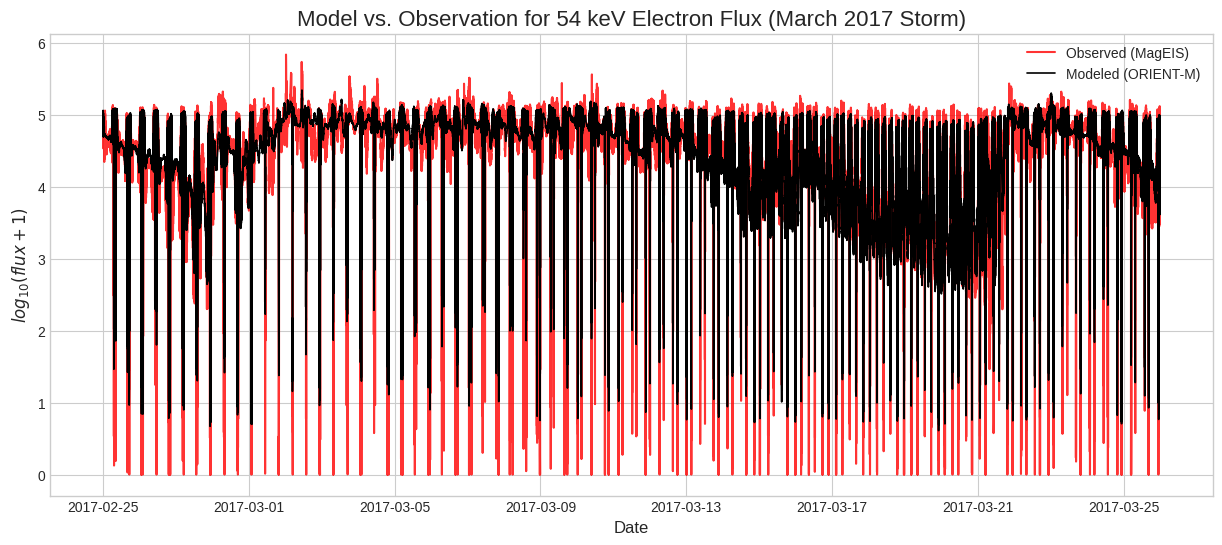

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

results_df = pd.DataFrame({
    'Observed_Flux': y_test_storm.values.flatten(),
    'Modeled_Flux': y_pred_storm.flatten()
}, index=y_test_storm.index)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 6))

plt.plot(results_df.index, results_df['Observed_Flux'], color='red', label='Observed (MagEIS)', alpha=0.8)
plt.plot(results_df.index, results_df['Modeled_Flux'], color='black', label='Modeled (ORIENT-M)', linewidth=1.2)

plt.title('Model vs. Observation for 54 keV Electron Flux (March 2017 Storm)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('$log_{10}(flux+1)$', fontsize=12)
plt.legend()
plt.savefig("ch11_storm_modelvsobservation_v1", dpi=300, bbox_inches='tight')

plt.show()

In [23]:
plt.savefig("ch3_storm_modelvsobservation_v1", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [24]:
model_save_path = '/content/drive/MyDrive/Radiation_Belt_Project/data/ORIENT_M_54keV_model.keras'

#save the model
model_54keV.save(model_save_path)
